### Extract Data from NEA Downloaded Pdfs

In [3]:
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import csv
import numpy as np

# Path setup
folder_path = os.path.expanduser("~/Downloads/drive-download-20251019T092634Z-1-001/")

# Base dates for each (year, month) - first day of the Nepali month in Gregorian
base_dates = {
    (2081, 1): datetime(2024, 4, 13),   # Baisakh
    (2081, 2): datetime(2024, 5, 14),   # Jestha
    (2081, 3): datetime(2024, 6, 14),   # Asadh
    (2081, 4): datetime(2024, 7, 16),   # Shrawan
    (2081, 5): datetime(2024, 8, 17),   # Bhadra
    (2081, 6): datetime(2024, 9, 17),   # Ashwin
    (2081, 7): datetime(2024, 10, 17),  # Kartik
    (2081, 8): datetime(2024, 11, 16),  # Mangsir
    (2081, 9): datetime(2024, 12, 16),  # Poush
    (2081, 10): datetime(2025, 1, 14),  # Magh
    (2081, 11): datetime(2025, 2, 13),  # Falgun
    (2081, 12): datetime(2025, 3, 14),  # Chaitra
    (2082, 1): datetime(2025, 4, 14),   # Baisakh
    (2082, 2): datetime(2025, 5, 15),   # Jestha
    (2082, 3): datetime(2025, 6, 15),   # Ashadh
    (2082, 4): datetime(2025, 7, 17),   # Shrawan
    (2082, 5): datetime(2025, 8, 17),   # Bhadra
    (2082, 6): datetime(2025, 9, 17),   # Ashwin
}

# Get all LogSheet files
all_files = [f for f in os.listdir(folder_path) if f.startswith('LogSheet') and f.endswith('.xlsx') and not f.startswith('~$')]
print(f"Found {len(all_files)} LogSheet files: {all_files}")

data = []

for filename in all_files:
    # Extract year and month from filename
    match = re.search(r'LogSheet (\d{4})-(\d{2})', filename)
    if not match:
        print(f"Could not parse year/month from {filename}; skipping.")
        continue
    year = int(match.group(1))
    month = int(match.group(2))
    key = (year, month)
    if key not in base_dates:
        print(f"No base date for {year}-{month}; skipping {filename}.")
        continue
    base_date = base_dates[key]
    print(f"Processing {filename}: Year {year}, Month {month}, Base date {base_date.strftime('%Y-%m-%d')}")

    full_path = os.path.join(folder_path, filename)
    try:
        # Load all sheets
        wb = pd.ExcelFile(full_path)
        sheet_names = wb.sheet_names
        print(f"  Found {len(sheet_names)} sheets in {filename}: {sheet_names}")

        for sheet in sheet_names:
            if sheet.startswith('NSAMPLE') or sheet == 'Sheet10' or sheet == '00' or not re.match(r'^\d{1,2}$', sheet):
                continue
            try:
                day = int(sheet)
                if day < 1 or day > 31:
                    continue
                
                # Nepali and Gregorian dates
                nepali_str_full = f"{year}/{month:02d}/{day:02d}"
                greg_date = base_date + timedelta(days=day - 1)
                greg_str = greg_date.strftime('%Y-%m-%d')
                
                df = pd.read_excel(full_path, sheet_name=sheet, engine='openpyxl', header=None)
               
                # Find Daily Load Curve cell
                curve_row = None
                curve_col = None
                for i in range(len(df)):
                    for j in range(len(df.columns)):
                        cell_val = str(df.iloc[i, j])
                        if pd.notna(cell_val) and 'Daily Load Curve' in cell_val:
                            curve_row = i
                            curve_col = j
                            print(f"  Found curve at row {i}, col {j} in sheet {sheet} of {filename}")
                            break
                    if curve_row is not None:
                        break
                if curve_row is None:
                    continue
               
                # Hours row
                hours_row = curve_row + 2
                times_col_start = curve_col + 1
                times_series = df.iloc[hours_row, times_col_start:times_col_start + 25].dropna()
                times_str = times_series.astype(str).tolist()
                n_times = len(times_str)
                if n_times < 24:
                    continue
               
                # Categories
                cat_start_row = curve_row + 3
                cat_names = ['IPP', 'NEA_SUB', 'NEA_ROR_PROR', 'IMPORT', 'NEA_STORAGE',
                             'INTERRUPTION', 'SYSTEM_LOAD', 'EXPORT', 'NATIONAL_LOAD']
                hourly_data = {}
                for i, cat in enumerate(cat_names):
                    row = cat_start_row + i
                    if row >= len(df):
                        break
                    vals_series = df.iloc[row, times_col_start:times_col_start + n_times].dropna()
                    vals = pd.to_numeric(vals_series, errors='coerce').fillna(0).values
                    if len(vals) > 0:
                        hourly_data[cat] = vals[:24]
               
                if len(hourly_data) < 7:
                    continue
               
                # Fill missing
                for cat in cat_names:
                    if cat not in hourly_data:
                        hourly_data[cat] = np.zeros(24)
               
                # Daily totals (MWh)
                ipp_mwh = sum(hourly_data['IPP'])
                nea_sub_mwh = sum(hourly_data['NEA_SUB'])
                nea_ror_pror_mwh = sum(hourly_data['NEA_ROR_PROR'])
                nea_storage_mwh = sum(hourly_data['NEA_STORAGE'])
                nea_mwh = nea_ror_pror_mwh + nea_storage_mwh
                import_mwh = sum(hourly_data['IMPORT'])
                interruption_mwh = sum(hourly_data['INTERRUPTION'])
                export_vals = hourly_data['EXPORT']
                export_mwh = -sum(export_vals)  # Make positive
                national_load_mwh = sum(hourly_data['NATIONAL_LOAD'])
               
                total_available_mwh = ipp_mwh + nea_mwh + nea_sub_mwh + import_mwh - interruption_mwh
                net_energy_met_mwh = total_available_mwh - export_mwh
                energy_not_served_mwh = max(0, national_load_mwh - net_energy_met_mwh)
                net_exchange_india_mwh = import_mwh - export_mwh
               
                # Peak analysis
                national_load_vals = hourly_data['NATIONAL_LOAD']
                peak_idx = np.argmax(national_load_vals)
                peak_time_str = times_str[peak_idx].strip() if peak_idx < len(times_str) else '00:00'
                try:
                    time_parts = re.split(r'[:\s]', peak_time_str)[0:2]
                    peak_hh = int(time_parts[0])
                    peak_mm = int(time_parts[1]) if len(time_parts) > 1 else 0
                except:
                    peak_hh, peak_mm = 0, 0
               
                # Peak MW
                gen_mw = (hourly_data['IPP'][peak_idx] + hourly_data['NEA_ROR_PROR'][peak_idx] +
                          hourly_data['NEA_STORAGE'][peak_idx] + hourly_data['NEA_SUB'][peak_idx])
                import_mw = hourly_data['IMPORT'][peak_idx]
                recorded_peak_avail_mw = gen_mw + import_mw
                export_mw_peak = -hourly_data['EXPORT'][peak_idx]
                national_peak = national_load_vals[peak_idx]
                interruption_mw_peak = hourly_data['INTERRUPTION'][peak_idx]
                demand_met_peak_mw = national_peak - interruption_mw_peak
                deficit_mw = max(0, national_peak - (gen_mw + import_mw - interruption_mw_peak))
                peak_demand_req_mw = demand_met_peak_mw + interruption_mw_peak + deficit_mw
                net_exchange_india_mw_peak = import_mw - export_mw_peak
               
                # Structured row
                row = {
                    'Gregorian_Date': greg_str,
                    'Nepali_Date': nepali_str_full,
                    'NEA_MWh': round(nea_mwh, 3),
                    'NEA_Subsidiary_MWh': round(nea_sub_mwh, 3),
                    'IPP_MWh': round(ipp_mwh, 3),
                    'Import_MWh': round(import_mwh, 3),
                    'Total_Energy_Available_MWh': round(total_available_mwh, 3),
                    'Energy_Export_MWh': round(export_mwh, 3),
                    'Net_Energy_Met_INPS_Demand_MWh': round(net_energy_met_mwh, 3),
                    'Energy_Interruption_MWh': round(interruption_mwh, 3),
                    'Energy_Not_Served_Generation_Deficit_MWh': round(energy_not_served_mwh, 3),
                    'Energy_Requirement_MWh': round(national_load_mwh, 3),
                    'Net_Exchange_with_India_MWh': round(net_exchange_india_mwh, 3),
                    'Peak_Time_HH': peak_hh,
                    'Peak_Time_MM': peak_mm,
                    'Generation_MW': round(gen_mw, 3),
                    'Import_MW': round(import_mw, 3),
                    'Recorded_Peak_Availability_MW': round(recorded_peak_avail_mw, 3),
                    'Export_MW': round(export_mw_peak, 3),
                    'Demand_Met_at_Peak_Time_MW': round(demand_met_peak_mw, 3),
                    'Interruption_MW': round(interruption_mw_peak, 3),
                    'Deficit_MW': round(deficit_mw, 3),
                    'Peak_Demand_Requirement_MW': round(peak_demand_req_mw, 3),
                    'Net_Exchange_with_India_MW': round(net_exchange_india_mw_peak, 3)
                }
                data.append(row)
                print(f"    Processed sheet {sheet}: {nepali_str_full} | Peak at {peak_hh}:{peak_mm:02d} | National Load {national_load_mwh:.1f} MWh")
            except Exception as e:
                print(f"    Error in sheet {sheet} of {filename}: {e}")
                continue
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        continue

# Save all data
if data:
    output_file = 'all_extracted_data.csv'
    df_out = pd.DataFrame(data)
    df_out.to_csv(output_file, index=False)
    print(f"\nSaved {len(data)} rows from all files to {output_file}")
    
    # Preview
    print("\nPreview (first 10 rows):")
    print(df_out.head(10).to_string(index=False))
else:
    print("No data extracted from any file.")

Found 18 LogSheet files: ['LogSheet 2081-09-Poush.xlsx', 'LogSheet 2082-04-Shrawan.xlsx', 'LogSheet 2082-02-Jestha.xlsx', 'LogSheet 2081-01-Baisakh.xlsx', 'LogSheet 2081-08-Mangsir.xlsx', 'LogSheet 2081-12-Chaitra.xlsx', 'LogSheet 2082-03-Ashadh.xlsx', 'LogSheet 2081-02-Jestha.xlsx', 'LogSheet 2081-03-Asadh.xlsx', 'LogSheet 2081-10-Magh.xlsx', 'LogSheet 2081-04-Shrawan.xlsx', 'LogSheet 2082-06-Ashwin.xlsx', 'LogSheet 2081-05-Bhadra.xlsx', 'LogSheet 2081-06-Ashwin.xlsx', 'LogSheet 2082-01-Baisakh.xlsx', 'LogSheet 2081-07-Kartik.xlsx', 'LogSheet 2082-05-Bhadra.xlsx', 'LogSheet 2081-11-Falgun.xlsx']
Processing LogSheet 2081-09-Poush.xlsx: Year 2081, Month 9, Base date 2024-12-16
Error loading LogSheet 2081-09-Poush.xlsx: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
Processing LogSheet 2082-04-Shrawan.xlsx: Year 2082, Month 4, Base date 2025-07-17
Error loading LogSheet 2082-04-Shrawan.xlsx: Missing optional dependency 'openpyxl'.  Use pip or conda to inst

### Load data extracted from NEA Website

In [10]:
import os
import pandas as pd
from datetime import datetime, timedelta
import re
import csv
import numpy as np

folder_path = os.path.expanduser("~/Downloads/drive-download-20251019T092634Z-1-001/")
df = pd.read_csv(folder_path+'combined_time_series.csv')

### Fill missing values and remove duplicates


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming your DataFrame is already loaded as 'df' from the CSV
# If not, load it first: df = pd.read_csv('your_file.csv')

# Step 1: Parse Gregorian_Date to datetime
df['Gregorian_Date'] = pd.to_datetime(df['Gregorian_Date'])

# Step 1.5: Handle duplicates in dates BEFORE setting index
# Check for duplicates
print("Number of duplicate dates:", df['Gregorian_Date'].duplicated().sum())

# Display duplicate dates if any
if df['Gregorian_Date'].duplicated().sum() > 0:
    duplicates = df[df['Gregorian_Date'].duplicated(keep=False)].sort_values('Gregorian_Date')
    print("Duplicate dates sample:")
    print(duplicates[['Gregorian_Date', 'NEA_MWh']].head(10))  # Show sample columns

# Option A: Drop duplicates, keeping the first occurrence (common for time series errors)
df = df.drop_duplicates(subset='Gregorian_Date', keep='first')

# Option B: If you want to aggregate (e.g., sum energy values for same day), uncomment below:
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# df = df.groupby('Gregorian_Date').agg({col: 'sum' if 'MWh' in col or 'MW' in col else 'mean' for col in numeric_cols})
# Non-numeric like Peak_Time_HH/MM would use mean; adjust as needed.

print(f"After handling duplicates: {len(df)} rows")

# Now set as index
df = df.set_index('Gregorian_Date')

# Drop the Unnamed: 0 column if it's just an index artifact
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Step 2: Sort by date to ensure chronological order
df = df.sort_index()

# Step 3: Identify the full date range and check for missing dates
start_date = df.index.min()
end_date = df.index.max()
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to include all days, which will introduce NaNs for missing dates
# Now safe since index is unique
df_full = df.reindex(full_date_range)

# Display missing dates summary
missing_dates = df_full.index[df_full['NEA_MWh'].isna()]  # Using NEA_MWh as proxy
print(f"Original data points (after dedup): {len(df)}")
print(f"Full range days: {len(full_date_range)}")
print(f"Missing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Missing dates:", missing_dates[:10].tolist())  # Show first 10

# Step 4: Fill missing values based on patterns
# For time series energy data, a combination of:
# - Forward/Backward fill for short gaps (business continuity)
# - Interpolation for trends (linear for smooth daily changes)
# - Group-wise mean for seasonal/day-of-week patterns (e.g., weekends lower demand)


df_full = df_full.fillna(method='ffill').fillna(method='bfill')

# Then, linear interpolation for remaining NaNs (good for trends)
# Apply to numeric columns only
numeric_cols = df_full.select_dtypes(include=[np.number]).columns
df_full[numeric_cols] = df_full[numeric_cols].interpolate(method='linear', limit_direction='both')

# For higher accuracy, impute based on day-of-week patterns (e.g., avg for Mondays)
# Create day-of-week feature
df_full['day_of_week'] = df_full.index.dayofweek  # 0=Monday, 6=Sunday

# For each numeric column, compute mean by day_of_week from non-missing data (original df)
for col in numeric_cols:
    day_means = df.groupby(df.index.dayofweek)[col].mean()
    df_full[col] = df_full[col].fillna(df_full['day_of_week'].map(day_means))

# Optional: Seasonal pattern by month (for longer-term cycles)
df_full['month'] = df_full.index.month
for col in numeric_cols:
    month_means = df.groupby(df.index.month)[col].mean()
    df_full[col] = df_full[col].fillna(df_full['month'].map(month_means))

# Drop the temporary columns if not needed
df_full = df_full.drop(columns=['day_of_week', 'month'])

# Step 5: Reset index if you want Gregorian_Date as a column again
df_filled = df_full.reset_index()
df_filled.rename(columns={'index': 'Gregorian_Date'}, inplace=True)

# Verify: Check for any remaining NaNs
print("\nRemaining NaNs per column:")
print(df_filled.isna().sum())

# Display sample
print("\nSample of filled data:")
print(df_filled.head(10))

# Save the filled DataFrame if needed
# df_filled.to_csv('filled_energy_data.csv', index=False)

Number of duplicate dates: 15
Duplicate dates sample:
    Gregorian_Date  NEA_MWh
185     2023-04-06   6789.0
186     2023-04-06   6789.0
290     2023-08-01   9085.0
291     2023-08-01   7948.0
292     2023-08-02   8871.0
293     2023-08-02   9168.0
294     2023-08-03   8871.0
295     2023-08-03   9247.0
299     2023-08-07   9707.0
300     2023-08-07   8566.0
After handling duplicates: 716 rows
Original data points (after dedup): 716
Full range days: 859
Missing dates: 143
Missing dates: [Timestamp('2022-09-09 00:00:00'), Timestamp('2022-09-18 00:00:00'), Timestamp('2022-10-04 00:00:00'), Timestamp('2022-10-06 00:00:00'), Timestamp('2022-10-09 00:00:00'), Timestamp('2022-10-12 00:00:00'), Timestamp('2022-10-18 00:00:00'), Timestamp('2022-10-20 00:00:00'), Timestamp('2022-10-30 00:00:00'), Timestamp('2022-10-31 00:00:00')]

Remaining NaNs per column:
Gregorian_Date                              0
Nepali_Date                                 0
NEA_MWh                                     0


/var/folders/6v/5fzs84sd3c78pfkfjs42mfh40000gn/T/ipykernel_21518/2633264143.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full = df_full.fillna(method='ffill').fillna(method='bfill')


In [12]:
df_filled_1 = df_filled

### Open Extracted data from Sushil sir's file

In [13]:
folder_path = os.path.expanduser("~/Downloads/drive-download-20251019T092634Z-1-001/")
df2 = pd.read_csv(folder_path+'all_extracted_data.csv')

### Rows after 2025-01-11

In [14]:
import pandas as pd
from datetime import datetime

# Assuming your DataFrame is 'df2' with 'Gregorian_Date' as string/object column

# Step 1: Convert 'Gregorian_Date' to datetime (fixes the TypeError)
df2['Gregorian_Date'] = pd.to_datetime(df2['Gregorian_Date'])

# Step 2: Define the cutoff date
cutoff_date = pd.to_datetime('2025-01-11')

# Step 3: Extract rows after the cutoff (strictly greater than)
df_after = df2[df2['Gregorian_Date'] > cutoff_date].copy()

# If you want inclusive (>=), use >= instead of >
# df_after = df2[df2['Gregorian_Date'] >= cutoff_date].copy()

# Verify
print(f"Original rows: {len(df2)}")
print(f"Rows after {cutoff_date.date()}: {len(df_after)}")
print("\nFirst few rows after cutoff:")
print(df_after.head())

# If Gregorian_Date is the index (after setting it earlier):
# df_after = df2[df2.index > cutoff_date].copy()

# Save or use as needed
# df_after.to_csv('data_after_2025-01-11.csv', index=False)

Original rows: 418
Rows after 2025-01-11: 275

First few rows after cutoff:
   Gregorian_Date Nepali_Date  NEA_MWh  NEA_Subsidiary_MWh   IPP_MWh  \
27     2025-01-12  2081/09/28  6982.36              4848.1  14851.18   
28     2025-01-13  2081/09/29  7037.40              5128.2  14773.80   
29     2025-07-17  2082/04/01  7714.60             13408.8  37610.60   
30     2025-07-18  2082/04/02  8233.70             14173.7  35422.50   
31     2025-07-19  2082/04/03  7777.30             14242.5  38283.24   

    Import_MWh  Total_Energy_Available_MWh  Energy_Export_MWh  \
27      7096.0                    32527.64                0.0   
28      7346.0                    31915.40               14.4   
29       124.5                    58858.50            16528.6   
30       135.6                    57965.50            15956.1   
31       101.0                    60404.04            16559.5   

    Net_Energy_Met_INPS_Demand_MWh  Energy_Interruption_MWh  ...  \
27                        32527.

### Check missing values

In [15]:
import pandas as pd
import numpy as np


df = df_after
# Assuming your DataFrame is 'df' (or 'df_filled', 'df2') with 'Gregorian_Date' as datetime column or index
# Ensure it's datetime first
if df['Gregorian_Date'].dtype == 'object':
    df['Gregorian_Date'] = pd.to_datetime(df['Gregorian_Date'])

# If using index (recommended for time series):
# df = df.set_index('Gregorian_Date')

# Step 1: Sort by date
df = df.sort_values('Gregorian_Date')  # Or df.sort_index() if index

# Step 2: Create full date range
start_date = df['Gregorian_Date'].min()  # Or df.index.min()
end_date = df['Gregorian_Date'].max()    # Or df.index.max()
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

print(f"Date range: {start_date.date()} to {end_date.date()} ({len(full_date_range)} days)")
print(f"Data points: {len(df)}")

# Step 3: Reindex to find missings (introduces NaNs for missing dates)
df_sorted = df.set_index('Gregorian_Date')  # Set index temporarily if not already
df_reindexed = df_sorted.reindex(full_date_range)

# Step 4: Identify missing dates (using a non-null column as proxy, e.g., NEA_MWh)
missing_mask = df_reindexed['NEA_MWh'].isna()  # Adjust column if needed
missing_dates = df_reindexed.index[missing_mask]

print(f"\nMissing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Missing dates list:")
    print(missing_dates.tolist())  # Or missing_dates for DatetimeIndex
    print("\nFirst 10 missing:")
    print(missing_dates[:10])
else:
    print("No missing dates found!")

# Optional: Export missing dates to CSV
# missing_df = pd.DataFrame({'Missing_Date': missing_dates})
# missing_df.to_csv('missing_dates.csv', index=False)

Date range: 2025-01-12 to 2025-10-15 (277 days)
Data points: 275

Missing dates: 2
Missing dates list:
[Timestamp('2025-03-24 00:00:00'), Timestamp('2025-07-16 00:00:00')]

First 10 missing:
DatetimeIndex(['2025-03-24', '2025-07-16'], dtype='datetime64[ns]', freq=None)


### Fill missing values and remove duplicates

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming your DataFrame is already loaded as 'df' from the CSV
# If not, load it first: df = pd.read_csv('your_file.csv')

# Step 1: Parse Gregorian_Date to datetime
df['Gregorian_Date'] = pd.to_datetime(df['Gregorian_Date'])

# Step 1.5: Handle duplicates in dates BEFORE setting index
# Check for duplicates
print("Number of duplicate dates:", df['Gregorian_Date'].duplicated().sum())

# Display duplicate dates if any
if df['Gregorian_Date'].duplicated().sum() > 0:
    duplicates = df[df['Gregorian_Date'].duplicated(keep=False)].sort_values('Gregorian_Date')
    print("Duplicate dates sample:")
    print(duplicates[['Gregorian_Date', 'NEA_MWh']].head(10))  # Show sample columns

# Option A: Drop duplicates, keeping the first occurrence (common for time series errors)
df = df.drop_duplicates(subset='Gregorian_Date', keep='first')

# Option B: If you want to aggregate (e.g., sum energy values for same day), uncomment below:
# numeric_cols = df.select_dtypes(include=[np.number]).columns
# df = df.groupby('Gregorian_Date').agg({col: 'sum' if 'MWh' in col or 'MW' in col else 'mean' for col in numeric_cols})
# Non-numeric like Peak_Time_HH/MM would use mean; adjust as needed.

print(f"After handling duplicates: {len(df)} rows")

# Now set as index
df = df.set_index('Gregorian_Date')

# Drop the Unnamed: 0 column if it's just an index artifact
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Step 2: Sort by date to ensure chronological order
df = df.sort_index()

# Step 3: Identify the full date range and check for missing dates
start_date = df.index.min()
end_date = df.index.max()
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Reindex to include all days, which will introduce NaNs for missing dates
# Now safe since index is unique
df_full = df.reindex(full_date_range)

# Display missing dates summary
missing_dates = df_full.index[df_full['NEA_MWh'].isna()]  # Using NEA_MWh as proxy
print(f"Original data points (after dedup): {len(df)}")
print(f"Full range days: {len(full_date_range)}")
print(f"Missing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print("Missing dates:", missing_dates[:10].tolist())  # Show first 10

# Step 4: Fill missing values based on patterns
# For time series energy data, a combination of:
# - Forward/Backward fill for short gaps (business continuity)
# - Interpolation for trends (linear for smooth daily changes)
# - Group-wise mean for seasonal/day-of-week patterns (e.g., weekends lower demand)

# First, ffill/bfill for any short gaps
df_full = df_full.fillna(method='ffill').fillna(method='bfill')

# Then, linear interpolation for remaining NaNs (good for trends)
# Apply to numeric columns only
numeric_cols = df_full.select_dtypes(include=[np.number]).columns
df_full[numeric_cols] = df_full[numeric_cols].interpolate(method='linear', limit_direction='both')

# For higher accuracy, impute based on day-of-week patterns (e.g., avg for Mondays)
# Create day-of-week feature
df_full['day_of_week'] = df_full.index.dayofweek  # 0=Monday, 6=Sunday

# For each numeric column, compute mean by day_of_week from non-missing data (original df)
for col in numeric_cols:
    day_means = df.groupby(df.index.dayofweek)[col].mean()
    df_full[col] = df_full[col].fillna(df_full['day_of_week'].map(day_means))

# Optional: Seasonal pattern by month (for longer-term cycles)
df_full['month'] = df_full.index.month
for col in numeric_cols:
    month_means = df.groupby(df.index.month)[col].mean()
    df_full[col] = df_full[col].fillna(df_full['month'].map(month_means))

# Drop the temporary columns if not needed
df_full = df_full.drop(columns=['day_of_week', 'month'])

# Step 5: Reset index if you want Gregorian_Date as a column again
df_filled = df_full.reset_index()
df_filled.rename(columns={'index': 'Gregorian_Date'}, inplace=True)

# Verify: Check for any remaining NaNs
print("\nRemaining NaNs per column:")
print(df_filled.isna().sum())

# Display sample
print("\nSample of filled data:")
print(df_filled.head(10))

# Save the filled DataFrame if needed
# df_filled.to_csv('filled_energy_data.csv', index=False)

Number of duplicate dates: 0
After handling duplicates: 275 rows
Original data points (after dedup): 275
Full range days: 277
Missing dates: 2
Missing dates: [Timestamp('2025-03-24 00:00:00'), Timestamp('2025-07-16 00:00:00')]

Remaining NaNs per column:
Gregorian_Date                              0
Nepali_Date                                 0
NEA_MWh                                     0
NEA_Subsidiary_MWh                          0
IPP_MWh                                     0
Import_MWh                                  0
Total_Energy_Available_MWh                  0
Energy_Export_MWh                           0
Net_Energy_Met_INPS_Demand_MWh              0
Energy_Interruption_MWh                     0
Energy_Not_Served_Generation_Deficit_MWh    0
Energy_Requirement_MWh                      0
Net_Exchange_with_India_MWh                 0
Peak_Time_HH                                0
Peak_Time_MM                                0
Generation_MW                               0
Import_MW

/var/folders/6v/5fzs84sd3c78pfkfjs42mfh40000gn/T/ipykernel_21518/3442604944.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full = df_full.fillna(method='ffill').fillna(method='bfill')


In [17]:
df_filled_2 = df_filled
df_filled_2

,Gregorian_Date,Nepali_Date,NEA_MWh,NEA_Subsidiary_MWh,IPP_MWh,Import_MWh,Total_Energy_Available_MWh,Energy_Export_MWh,Net_Energy_Met_INPS_Demand_MWh,Energy_Interruption_MWh,...,Peak_Time_MM,Generation_MW,Import_MW,Recorded_Peak_Availability_MW,Export_MW,Demand_Met_at_Peak_Time_MW,Interruption_MW,Deficit_MW,Peak_Demand_Requirement_MW,Net_Exchange_with_India_MW
0,2025-01-12,2081/09/28,6982.36,4848.1,14851.18,7096.00,32527.64,0.00,32527.64,1250.0,...,0.0,1033.74,191.0,1224.74,0.0,0.0,0.0,0.0,0.0,191.0
1,2025-01-13,2081/09/29,7037.40,5128.2,14773.80,7346.00,31915.40,14.40,31901.00,2370.0,...,0.0,1008.40,242.0,1250.40,-0.0,0.0,0.0,0.0,0.0,242.0
2,2025-01-14,2081/10/01,5773.60,4782.4,14756.90,7164.10,31157.00,0.00,31157.00,1320.0,...,0.0,955.80,265.2,1221.00,0.0,0.0,0.0,0.0,0.0,265.2
3,2025-01-15,2081/10/02,7044.10,5171.8,14223.06,7067.24,32286.20,0.00,32286.20,1220.0,...,0.0,917.20,270.2,1187.40,0.0,0.0,0.0,0.0,0.0,270.2
4,2025-01-16,2081/10/03,7418.77,5128.1,14796.62,7424.00,33187.49,0.00,33187.49,1580.0,...,0.0,945.88,288.0,1233.88,0.0,0.0,0.0,0.0,0.0,288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2025-10-11,2082/06/25,8258.60,14936.5,35113.00,0.00,58308.10,24586.00,33722.10,0.0,...,0.0,2566.70,0.0,2566.70,1021.1,0.0,0.0,0.0,0.0,-1021.1
273,2025-10-12,2082/06/26,8270.50,15565.9,36599.10,0.00,60435.50,24201.22,36234.28,0.0,...,0.0,2474.10,0.0,2474.10,1064.6,0.0,0.0,0.0,0.0,-1064.6
274,2025-10-13,2082/06/27,8543.70,15184.1,37599.60,0.00,61327.40,23804.91,37522.49,0.0,...,0.0,2538.20,0.0,2538.20,1008.0,0.0,0.0,0.0,0.0,-1008.0
275,2025-10-14,2082/06/28,8708.90,15362.7,35687.50,0.00,59759.10,24056.30,35702.80,0.0,...,0.0,2457.30,0.0,2457.30,994.8,0.0,0.0,0.0,0.0,-994.8


### Merge two data sources

In [18]:
merged_df = pd.concat([df_filled_1, df_filled_2], ignore_index=True)

# Step 2: Sort by Gregorian_Date (ascending, default)
merged_df = merged_df.sort_values('Gregorian_Date').reset_index(drop=True)

# Verify
print(f"Merged shape: {merged_df.shape}")
print(f"Date range: {merged_df['Gregorian_Date'].min()} to {merged_df['Gregorian_Date'].max()}")
print("\nSample head:")
print(merged_df.head())
print("\nSample tail:")
print(merged_df.tail())

Merged shape: (1136, 24)
Date range: 2022-09-06 00:00:00 to 2025-10-15 00:00:00

Sample head:
  Gregorian_Date Nepali_Date  NEA_MWh  NEA_Subsidiary_MWh  IPP_MWh  \
0     2022-09-06  2079/05/21  10325.0             12791.0  19119.0   
1     2022-09-07  2079/05/22  11012.0             12479.0  18917.0   
2     2022-09-08  2079/05/23  10881.0             12729.0  18668.0   
3     2022-09-09  2079/05/23  10881.0             12729.0  18668.0   
4     2022-09-10  2079/05/25   8996.0             12557.0  19032.0   

   Import_MWh  Total_Energy_Available_MWh  Energy_Export_MWh  \
0       688.0                   42923.519             8646.0   
1       418.0                   42826.000             8117.0   
2       496.0                   42774.000             7668.0   
3       496.0                   42774.000             7668.0   
4       817.0                   41403.000             9598.0   

   Net_Energy_Met_INPS_Demand_MWh  Energy_Interruption_MWh  ...  Peak_Time_MM  \
0                  

In [19]:
# merged_df = merged_df.set_index('Gregorian_Date')
merged_df['Demand']= merged_df['Total_Energy_Available_MWh'] + merged_df['Import_MWh'] - merged_df['Export_MW']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 25 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Gregorian_Date                            1136 non-null   datetime64[ns]
 1   Nepali_Date                               1136 non-null   object        
 2   NEA_MWh                                   1136 non-null   float64       
 3   NEA_Subsidiary_MWh                        1136 non-null   float64       
 4   IPP_MWh                                   1136 non-null   float64       
 5   Import_MWh                                1136 non-null   float64       
 6   Total_Energy_Available_MWh                1136 non-null   float64       
 7   Energy_Export_MWh                         1136 non-null   float64       
 8   Net_Energy_Met_INPS_Demand_MWh            1136 non-null   float64       
 9   Energy_Interruption_MWh       

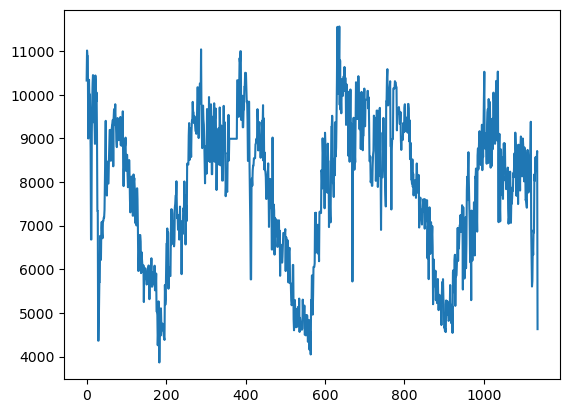

In [20]:
merged_df['NEA_MWh'].plot()
merged_df.info()

In [21]:
merged_df.to_csv("Merged_data.csv")